Author: Jonathan Gong

In [21]:
import pandas as pd
import os
import sys
import sktime
from sktime.annotation.hmm_learn import GMMHMM 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Data processing

##### Data Loading

In [22]:
# Load one of the CSV files to inspect its columns
sample_file = pd.read_csv('../data/raw/500030_2024-07-01_2024-09-30.csv')


In [23]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}', dtype={'template': 'str'}))

#### Data Processing

In [24]:
def dataprocessing(csv_files):

    # Extract the date, bgl, and msg_type columns from each CSV file
    each_bgl =[]
    for file in csv_files:
        each_df = file[["date", "bgl", "msg_type"]]
        each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
        each_df = each_df.dropna(subset=['date'])
        each_df = each_df.dropna(subset=["bgl"])
        each_df["msg_type"] = [
        1 if i == 'INTERVENTION_SNACK' else 2 if i == 'ANNOUNCE_MEAL' else 0
        for i in each_df["msg_type"]
        ]
        each_df = each_df.sort_values('date')
        # each_df.drop_duplicates(subset=['date'], inplace = True)
        # each_df.set_index('date', inplace=True)
        each_bgl.append(each_df)

    # Extract the date, time, and day columns from each df and split them into seperate days
    days_patients = []
    for bgl in each_bgl:
        # (hour:minute:second)
        bgl['time'] = bgl['date'].dt.time
        # (year-month-day)
        bgl['day'] = bgl['date'].dt.date
        # unique days
        unique_days = bgl['day'].unique()
        day_data = []
        for i, day in enumerate(unique_days):
            bgl_day = bgl[bgl['day'] == day]
            day_data.append(bgl_day[["date", "bgl"]])

        days_patients.append(day_data)

    # set index to date
    for patient_days in days_patients:
        for df in patient_days:
            df.set_index('date', inplace=True)

    # Scale BGL data
    patients_scaled = []
    scaler = StandardScaler()
    for patient_days in days_patients:
        scaled_data = scaler.fit_transform(pd.concat(patient_days))
        patients_scaled.append(scaled_data)
    
    # Normalize BGL data
    # patients_normalized = []
    # for patient_days in days_patients:
    #     print(pd.concat(patient_days))
    #     norm_data = pd.concat(patient_days)/max(pd.concat(patient_days))
    #     patients_normalized.append(norm_data)

    # Make ground truth labels for BGL data
    patients_labels = []
    for bgl in each_bgl:
        patients_labels.append(bgl[["msg_type"]])

    # return days_patients, patients_scaled, patients_normalized, patients_labels
    return days_patients, patients_scaled, patients_labels

# Model

In [25]:
def runGMMHMM(supervised, X, n_components, n_mix, n_iter, Y = "bruh"):

    # make intial parameters for GMMHMM model
    data_used = X
    n_components = 2 # Number of components in the GMMHMM
    kmeans = KMeans(n_clusters=n_components).fit(data_used)
    initial_means = kmeans.cluster_centers_

    if not supervised:
        model = GMMHMM(n_components=n_components, n_mix=n_mix, n_iter=n_iter, covariance_type = 'full',  verbose = True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        model.fit(X)
        return model
    else:
        model = GMMHMM(n_mix=n_mix, n_iter=n_iter, covariance_type = 'full', verbose=True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        print("supervised")
        model.fit_predict(X = X, Y = Y)
        return model

# Run

In [26]:
days_patients, patients_scaled, patients_labels = dataprocessing(csv_files)

C:\Users\jonat\AppData\Local\Temp\ipykernel_36416\2176003785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
C:\Users\jonat\AppData\Local\Temp\ipykernel_36416\2176003785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)


In [27]:
all_days_patient_0 = pd.concat(days_patients[0])
all_days_patient_1 = pd.concat(days_patients[1])

In [28]:
n_components = 3
model = runGMMHMM(supervised= False, n_components=n_components, X = all_days_patient_0, n_mix = 2, n_iter = 100)


c:\Users\jonat\Documents\Code\WAT.ai\bg_control-1\0_meal_identification\meal_identification\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jonat\Documents\Code\WAT.ai\bg_control-1\0_meal_identification\meal_identification\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jonat\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jonat\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1

In [49]:
test_data = all_days_patient_0
test_smoothed = gaussian_filter1d(all_days_patient_0, sigma=15)

hidden_states = model.predict(test_smoothed.reshape(-1, 1))


In [30]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([0, 1], dtype=int64)

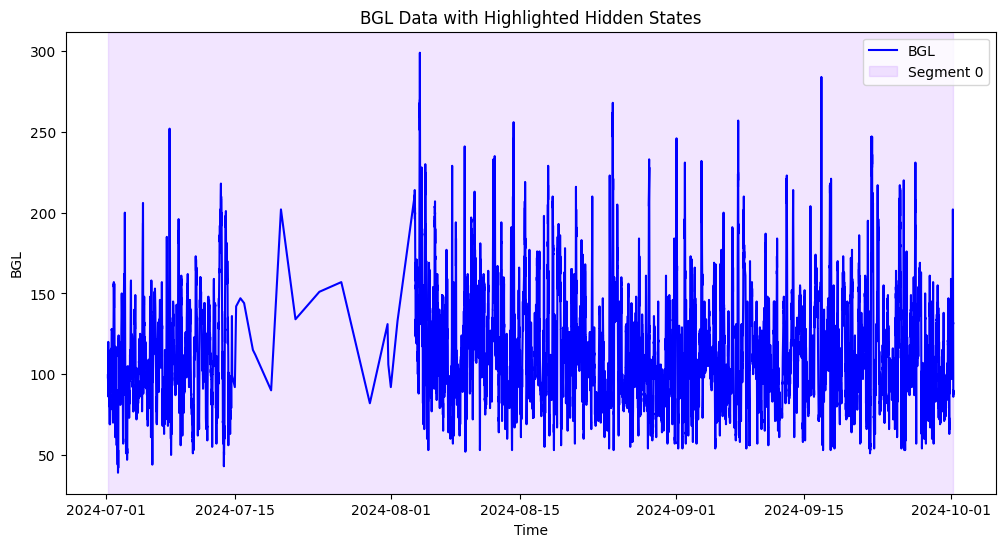

In [32]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Convert numpy array back to DataFrame
bruh = pd.DataFrame(test_smoothed, index=test_data.index, columns=['bgl'])

bruh = all_days_patient_0
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse_output=False)
Y_0 = encoder.fit_transform(patients_labels)

In [ ]:
n_components = 4
model = runGMMHMM(supervised= True, n_components=n_components, X = days_patients, n_mix = 16, n_iter = 100, Y = Y_0)

supervised


         1 -171218.95037991             +nan
         2 -160150.66424246  +11068.28613745
         3 -159471.50703840    +679.15720406
         4 -159317.00587918    +154.50115922
         5 -159244.45886877     +72.54701041
         6 -159197.39857737     +47.06029140
         7 -159160.62156115     +36.77701622
         8 -159128.82072976     +31.80083139
         9 -159099.84242041     +28.97830935
        10 -159072.68794447     +27.15447594
        11 -159046.85026424     +25.83768023
        12 -159022.07445777     +24.77580647
        13 -158998.25852010     +23.81593766
        14 -158975.40254180     +22.85597831
        15 -158953.57536519     +21.82717661
        16 -158932.88791922     +20.68744597
        17 -158913.46962081     +19.41829841
        18 -158895.44715644     +18.02246437
        19 -158878.92624748     +16.52090896
        20 -158863.97747880     +14.94876869
        21 -158850.62720876     +13.35027004
        22 -158838.85412503     +11.77308373
        23

In [ ]:
hidden_states = model.predict(pd.concat(days_patients[0][0:7]))

In [ ]:
np.unique(hidden_states)

array([0], dtype=int64)

1930


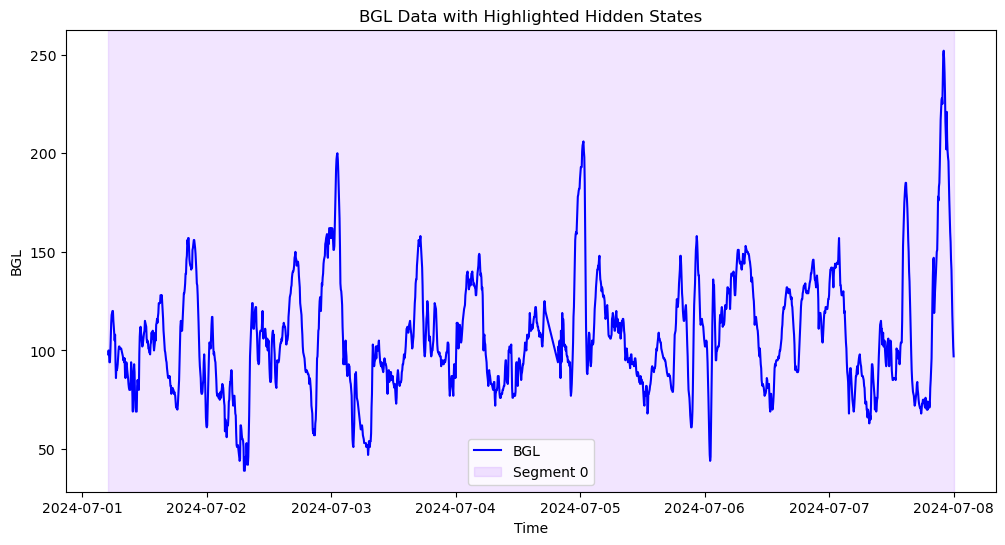

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))


bruh = pd.concat(days_patients[0][0:7])
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    print(len(masks))
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()